In [1]:
import sys
import numpy as np
import tensorflow as tf
import os
from tensorflow.contrib.lookup import MutableHashTable
from tensor2tensor.layers import common_layers

from tensor2tensor.models import transformer
sys.path.append('/workspace/MT/tensor2tensor/tensor2tensor/models/')
sys.path.append('/workspace/MT/tensor2tensor/tensor2tensor/utils/')

from transformer_test import TransformerTest
from transformer_cache import TransformerCache
from tensor2tensor.data_generators import problem_hparams
from tensor2tensor.data_generators import problem

In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
sys.path.append('/workspace/MT/t2t_data_generators/')

In [4]:
from generator import ShadENRUOpusProblem

In [5]:
shad_problem = ShadENRUOpusProblem()

In [6]:
data = shad_problem.generate_encoded_samples(
    '/workspace/MT/shad_nlp18_contextNMT/data_4prev/',
    '/workspace/MT/shad_nlp18_contextNMT/data_4prev/',
    problem.DatasetSplit.TRAIN
)

INFO:tensorflow:Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.src


[2018-04-26 13:52:06,083] Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.src


INFO:tensorflow:Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.dst


[2018-04-26 13:52:06,188] Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.dst


In [7]:
has_input = True
mode=tf.estimator.ModeKeys.TRAIN

hparams = transformer.transformer_base_single_gpu()
hparams.data_dir =  '/workspace/MT/shad_nlp18_contextNMT/data_4prev//'
p_hparams = shad_problem.get_hparams(hparams)

In [8]:
features_true = {
    "inputs": tf.placeholder(shape=[None, None, 1, 1], dtype=tf.int32, name="inputs"),
    "targets": tf.placeholder(shape=[None, None, 1, 1], dtype=tf.int32, name="inputs"),
    "target_space_id": tf.constant(1, dtype=tf.int32)
}

In [9]:
hparams.batch_size = 512
hparams.use_cache = True

## Initializing the model

In [10]:
model = TransformerCache(hparams, mode, p_hparams)

INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.


[2018-04-26 13:52:06,734] Unsetting shared_embedding_and_softmax_weights.


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-04-26 13:52:06,736] Setting T2TModel mode to 'train'


In [11]:
out_logits, _ = model(features_true)

INFO:tensorflow:Using variable initializer: uniform_unit_scaling


[2018-04-26 13:52:06,804] Using variable initializer: uniform_unit_scaling


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_22057_512.bottom


[2018-04-26 13:52:06,830] Transforming feature 'inputs' with symbol_modality_22057_512.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_23180_512.targets_bottom


[2018-04-26 13:52:07,211] Transforming 'targets' with symbol_modality_23180_512.targets_bottom


INFO:tensorflow:Building model body


[2018-04-26 13:52:07,312] Building model body


INFO:tensorflow:Transforming body output with symbol_modality_23180_512.top


[2018-04-26 13:52:14,821] Transforming body output with symbol_modality_23180_512.top


In [12]:
save_dict = {"/".join(["transformer"] + var.name[:-2].split('/')[1:]) : var for var in tf.global_variables()[5:]}

In [13]:
saver = tf.train.Saver(save_dict)
ckpt = tf.train.get_checkpoint_state('/workspace/MT/train/transformer/')

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
else:
    print("...no checkpoint found...")

INFO:tensorflow:Restoring parameters from /workspace/MT/train/transformer/model.ckpt-250000


[2018-04-26 13:52:18,656] Restoring parameters from /workspace/MT/train/transformer/model.ckpt-250000


In [15]:
new_saver = tf.train.Saver(tf.global_variables()[2:4])
new_ckpt = tf.train.get_checkpoint_state('/workspace/MT/train_cache_20/')

In [16]:
if new_ckpt and new_ckpt.model_checkpoint_path:
    new_saver.restore(sess, new_ckpt.model_checkpoint_path)
else:
    print("...no checkpoint found...")

...no checkpoint found...


In [17]:
logits = tf.squeeze(out_logits, axis=[2, 3])

loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=tf.reshape(out_logits, [-1, p_hparams.vocabulary['targets'].vocab_size]),
    labels=tf.reshape(features_true["targets"], [-1]))
loss = tf.reduce_mean(loss)

apply_grad = tf.train.AdamOptimizer(0.001).minimize(loss, var_list=tf.global_variables()[2:4])

In [18]:
#initialize adam's stuff
sess.run(tf.initialize_variables(tf.global_variables()[-6:]))

Instructions for updating:
Use `tf.variables_initializer` instead.


[2018-04-26 13:52:19,334] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/util/tf_should_use.py:107: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


In [19]:
data = shad_problem.generate_encoded_samples(
    '/workspace/MT/shad_nlp18_contextNMT/data_4prev/',
    '/workspace/MT/shad_nlp18_contextNMT/data_4prev/',
    problem.DatasetSplit.TRAIN,
)

INFO:tensorflow:Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.src


[2018-04-26 13:52:19,629] Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.src


INFO:tensorflow:Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.dst


[2018-04-26 13:52:19,814] Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.dst


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [21]:
from itertools import zip_longest

def box_hpaulj(LoL):
    return np.array(list(zip_longest(*LoL, fillvalue=0)), dtype=np.int32).T

def batch_iterator(data, batch_size, context_size, n_steps=1000):
    
    for k in range(n_steps):
        
        batch_list_inp = [[] for _ in range(context_size)]
        batch_list_targ = [[] for _ in range(context_size)]

        for batch_i in range(batch_size):
            for context_i, p in enumerate(data):
                batch_list_inp[context_i].append(p['inputs'])
                batch_list_targ[context_i].append(p['targets'])
                if context_i == context_size - 1:
                    break

        for b_inp, b_out in zip(batch_list_inp, batch_list_targ):
            yield {'inputs' : box_hpaulj(b_inp), 'targets' : box_hpaulj(b_out)}

## Fine-tuning the mixing matrices for cache vector and transformer embedding

In [22]:
data = shad_problem.generate_encoded_samples(
    '/workspace/MT/shad_nlp18_contextNMT/data_4prev/',
    '/workspace/MT/shad_nlp18_contextNMT/data_4prev/',
    problem.DatasetSplit.TRAIN,
)

INFO:tensorflow:Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.src


[2018-04-26 13:52:20,044] Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.src


INFO:tensorflow:Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.dst


[2018-04-26 13:52:20,193] Found vocab file: /workspace/MT/shad_nlp18_contextNMT/data_4prev/vocab_enru.dst


In [23]:
loss_data = []
mean_loss = []
iteration = 0
glob_iteration = 0
epoch = 0

In [ ]:
try:
    
    for it in batch_iterator(data, hparams.batch_size, 5, n_steps=10000):

        inputs = it['inputs'].reshape((it['inputs'].shape[0], it['inputs'].shape[1], 1, 1))
        targets = it['targets'].reshape((it['targets'].shape[0], it['targets'].shape[1], 1, 1))

        l, _ = sess.run([loss, apply_grad], feed_dict={
            features_true['inputs'] : inputs,
            features_true['targets'] : targets
        })

        loss_data.append(l)

        iteration += 1
        glob_iteration += 1

        if iteration == 5:
            sess.run(model.sentence_cache.Flush())
            iteration = 0

        if len(loss_data) == 100:
            clear_output(True)
            mean_loss.append(np.mean(loss_data))
            loss_data = []
            print("Epoch {}, Iteration {}, Mean loss {}".format(epoch, glob_iteration, mean_loss[-1]))

        if glob_iteration == 750000 // hparams.batch_size:
            epoch += 1
            glob_iteration = 0
            new_saver.save(sess, '/workspace/MT/train_cache_20/transformer_cache')
            
except KeyboardInterrupt:
    pass

Epoch 1, Iteration 236, Mean loss 6.492918014526367


In [ ]:
l

In [26]:
new_saver.save(sess, '/workspace/MT/train_cache/train_cache_20/transformer_cache')

'/workspace/MT/train_cache/transformer_cache'

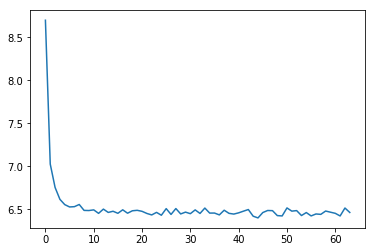

In [25]:
plt.plot(mean_loss)